In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import time
import json
import glob
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [4]:
import sys
sys.path.append('../')
from fog_dataloader import FogDataloader as fog
from models import multiview_vit as vit
from utils import SparkMET as sm
from utils import engine
import torch
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Check if there is GPU(s): {torch.cuda.is_available()}")

Check if there is GPU(s): True


In [5]:
import inference as inf

In [6]:
from models.ViT_explanation_generator import LRP

#### Visualize Attention Scores

In [7]:
data_loader_training, data_loader_validate, data_loader_testing = fog.Fog_DataLoader_npz_cv(batch_size = 32, 
                                                                                            kfold_id  = 8, 
                                                                                            SaveDir = '/data1/fog/Hamid/SparkMET/EXPs/', 
                                                                                            Exp_name = '00_VVT_BCE_0001_01_30_32', 
                                                                                            WeightR = False)

#================================ Summary of Dataset ==================#
number of training samples:   7960 | number of training fog cases:   141
number of validation samples: 828 | number of validation fog cases: 15
number of test samples:       2228 | number of test fog cases:       67
#======================================================================#


In [8]:
data_dict_vvt = {}

for batch in data_loader_training:
    # Assuming each batch is a dictionary with keys: 'input', 'class-label', 'vis', 'date_time'
    for i in range(len(batch['date_cycletime'])):
        date_cycletime = batch['date_cycletime'][i]
        data_dict_vvt[date_cycletime] = {
            'date_time': batch['date_time'][i],
            'vis': batch['vis'][i],
            'input': batch['input'][i],
            'label_class': batch['label_class'][i],
        }

#### VVT

In [14]:
config_vvt = sm.Get_model_config(img_size = 32, in_channel = 388, in_time = 4, embd_size = 1024, mlp_size = 512, 
                                      num_heads = 8, dropout = 0.3, num_layers  = 6, conv_type = '2d', embd_type = 'VVT').return_config()

In [10]:
FogNet = sm.SparkMET(config_vvt, 
                           SaveDir = '/data1/fog/Hamid/SparkMET/EXPs/', 
                           Exp_Name = '00_VVT_BCE_00005_01_30_32_LPR')

model_vvt, optimizer, loss_func = FogNet.compile(optmizer = 'adamw', loss = 'BCE', lr = 0.00005, wd = 0.01)

model_vvt.load_state_dict(torch.load('/data1/fog/Hamid/SparkMET/EXPs/00_VVT_BCE_00005_01_30_32_LPR/best_model_00_VVT_BCE_00005_01_30_32_LPR.pth'))

The number of model's parameters = 105214978


<All keys matched successfully>

In [11]:
model_vvt.eval()
attribution_generator_vvt = LRP(model_vvt)

In [15]:
for date_time, data in data_dict_vvt.items():

    transformer_attribution = attribution_generator_vvt.generate_LRP(data['input'].unsqueeze(0).cuda(0), method="transformer_attribution", index=data['label_class']).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 4, 4)
    transformer_attribution4 = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    data_dict_vvt[date_time]['lpr'] = transformer_attribution4.data.cpu().numpy()
  
    transformer_attribution32 = torch.nn.functional.interpolate(transformer_attribution, scale_factor=8, mode='bilinear')
    transformer_attribution32 = transformer_attribution32.reshape(32, 32)
    transformer_attribution32 = (transformer_attribution32 - transformer_attribution32.min()) / (transformer_attribution32.max() - transformer_attribution32.min())
    data_dict_vvt[date_time]['lpr32'] = transformer_attribution32.data.cpu().numpy()

RuntimeError: cuDNN error: CUDNN_STATUS_EXECUTION_FAILED

(1, 4, 4)


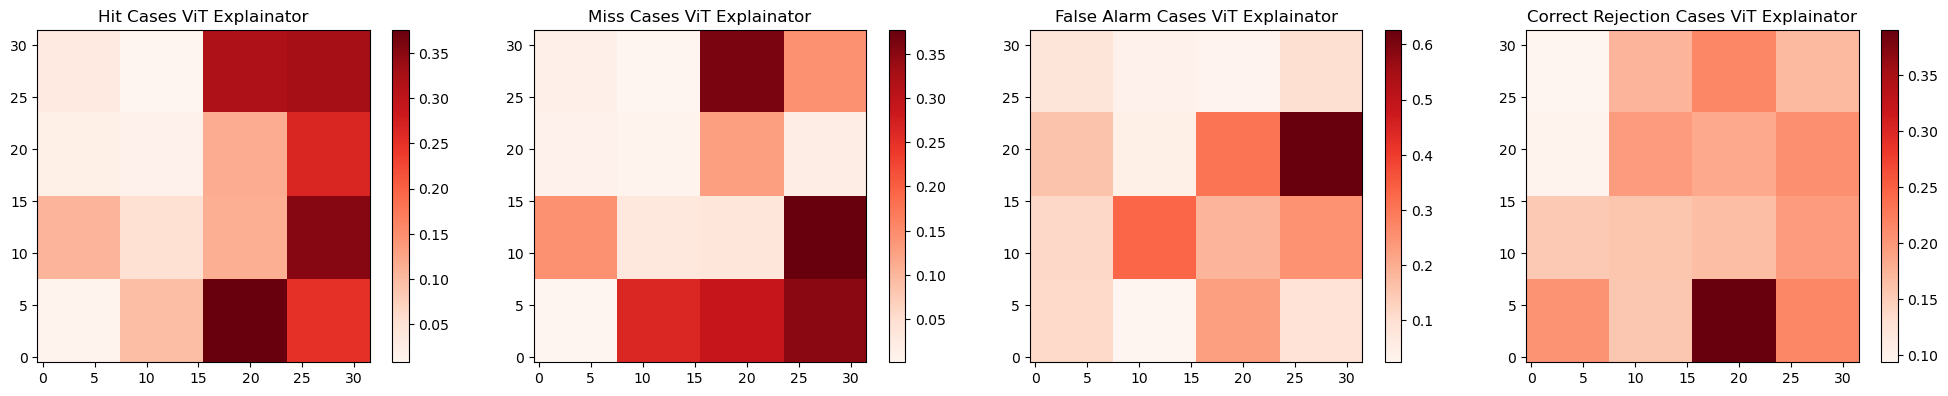

In [ ]:
_ = inf.XAI_ALLCASES_PLOT(data_dict_vvt, exp_name = '00_VVT_BCE_00005_01_30_32_LPR', threshold = 0.294, embd_type='VVT').global_plot(scale = 4)

### STT

In [20]:
data_dict_stt = {}

for batch in data_loader_training:
    # Assuming each batch is a dictionary with keys: 'input', 'class-label', 'vis', 'date_time'
    for i in range(len(batch['date_cycletime'])):
        date_cycletime = batch['date_cycletime'][i]
        data_dict_stt[date_cycletime] = {
            'date_time': batch['date_time'][i],
            'vis': batch['vis'][i],
            'input': batch['input'][i],
            'label_class': batch['label_class'][i],
        }

In [17]:
config_stt = sm.Get_model_config(img_size = 32, in_channel = 388, in_time = 4, embd_size = 1024, mlp_size = 512, 
                                      num_heads = 8, dropout = 0.3, num_layers  = 6, conv_type = '2d', embd_type = 'STT').return_config()

In [18]:
FogNet = sm.SparkMET(config_stt, 
                           SaveDir = '/data1/fog/Hamid/SparkMET/EXPs/', 
                           Exp_Name = '02_STT_BCE_0001_01_32_LPR')

model_stt, optimizer, loss_func = FogNet.compile(optmizer = 'adamw', loss = 'BCE', lr = 0.00005, wd = 0.01)

model_stt.load_state_dict(torch.load('/data1/fog/Hamid/SparkMET/EXPs/02_STT_BCE_0001_01_32_LPR/best_model_02_STT_BCE_0001_01_32_LPR.pth'))

The number of model's parameters = 86193154


<All keys matched successfully>

In [19]:
model_stt.eval()
attribution_generator_stt = LRP(model_stt)

In [21]:
for date_time, data in data_dict_stt.items():

    transformer_attribution = attribution_generator_stt.generate_LRP(data['input'].unsqueeze(0).cuda(0), method="transformer_attribution", index=data['label_class']).detach()
    transformer_attribution = transformer_attribution.reshape(1, 4, 4, 4)
    transformer_attribution4 = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    data_dict_stt[date_time]['lpr'] = transformer_attribution4.data.cpu().numpy()

    transformer_attribution32 = torch.nn.functional.interpolate(transformer_attribution, scale_factor=8, mode='bilinear')
    transformer_attribution32 = transformer_attribution32.reshape(4, 32, 32)
    transformer_attribution32 = (transformer_attribution32 - transformer_attribution32.min()) / (transformer_attribution32.max() - transformer_attribution32.min())
    data_dict_stt[date_time]['lpr32'] = transformer_attribution32.data.cpu().numpy()

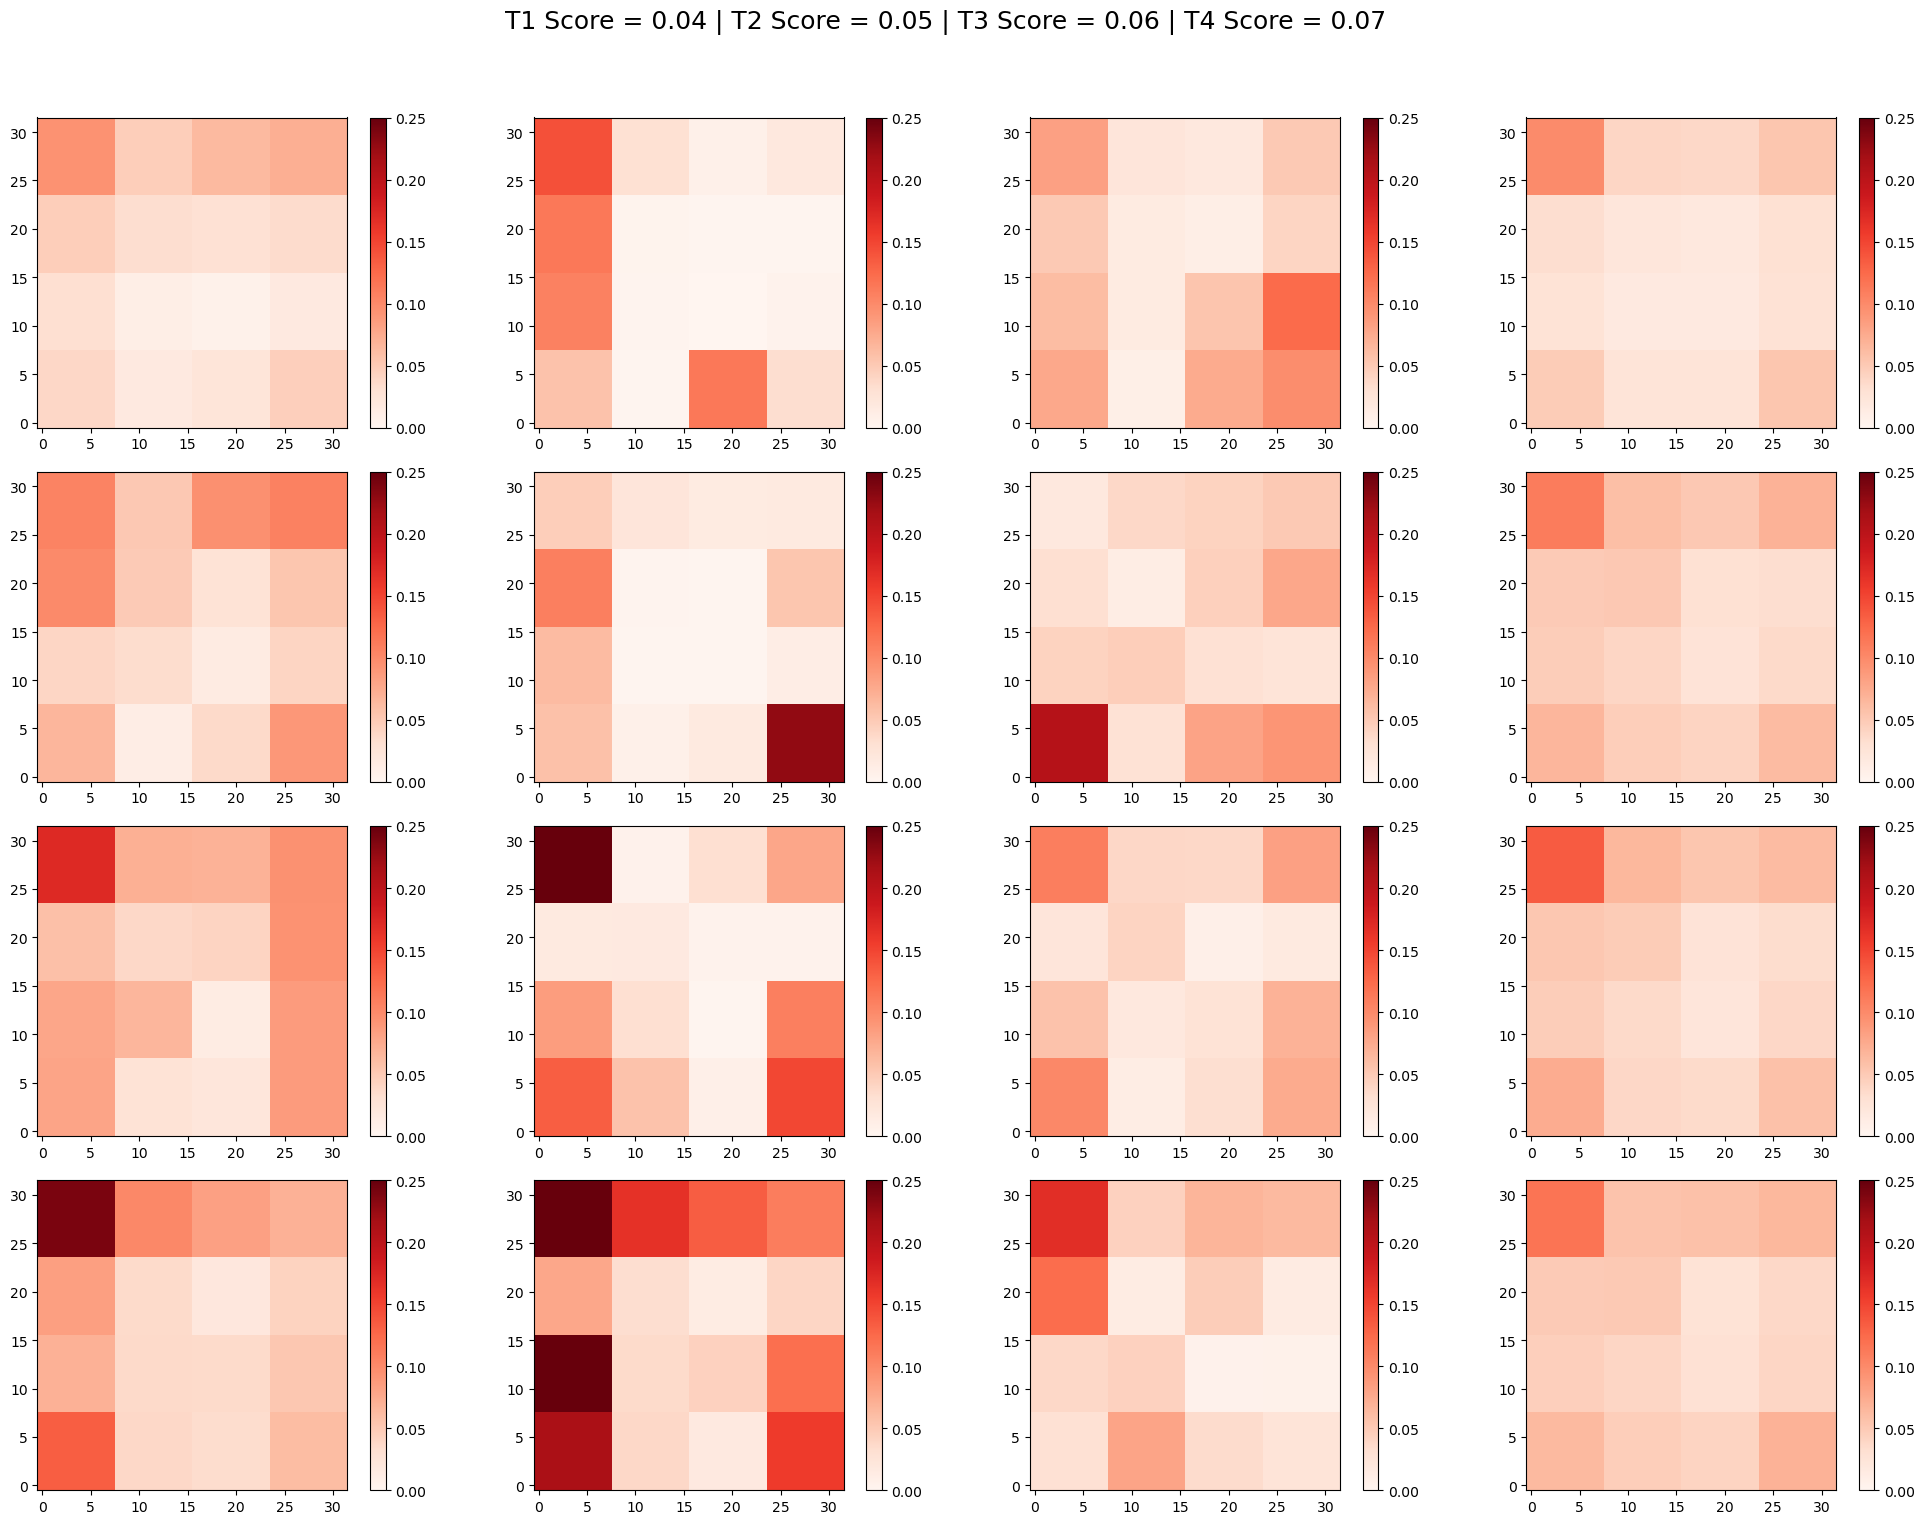

In [35]:
_ = inf.XAI_ALLCASES_PLOT(data_dict_stt, exp_name = '02_STT_BCE_0001_01_32_LPR', threshold = 0.165, embd_type='STT').global_plot(scale = 4)

In [ ]:
_ = inf.XAI_ALLCASES_PLOT(data_dict_stt, exp_name = '02_STT_BCE_0001_01_32_LPR', threshold = 0.165, embd_type='STT').global_plot(scale = 32)

### PIT_V2

In [28]:
config_pit = sm.Get_model_config(img_size = 32, in_channel = 388, in_time = 4, embd_size = 1024, mlp_size = 512, 
                                      num_heads = 8, dropout = 0.3, num_layers  = 6, conv_type = '2d', embd_type = 'PIT').return_config()

In [29]:
FogNet = sm.SparkMET(config_pit, 
                           SaveDir = '/data1/fog/Hamid/SparkMET/EXPs/', 
                           Exp_Name = '05_PIT_V2_LRP_32')

model_pit, optimizer, loss_func = FogNet.compile(optmizer = 'adamw', loss = 'BCE', lr = 0.00005, wd = 0.03)

model_pit.load_state_dict(torch.load('/data1/fog/Hamid/SparkMET/EXPs/05_PIT_V2_LRP_32/best_model_05_PIT_V2_LRP_32.pth'))

The number of model's parameters = 105284610


<All keys matched successfully>

In [30]:
model_pit.eval()
attribution_generator_pit = LRP(model_pit)

In [31]:
data_dict_pit = {}

for batch in data_loader_training:
    # Assuming each batch is a dictionary with keys: 'input', 'class-label', 'vis', 'date_time'
    for i in range(len(batch['date_cycletime'])):
        date_cycletime = batch['date_cycletime'][i]
        data_dict_pit[date_cycletime] = {
            'date_time': batch['date_time'][i],
            'vis': batch['vis'][i],
            'input': batch['input'][i],
            'label_class': batch['label_class'][i],
        }

In [32]:
for date_time, data in data_dict_pit.items():

    transformer_attribution = attribution_generator_pit.generate_LRP(data['input'].unsqueeze(0).cuda(0), method="transformer_attribution", index=data['label_class']).detach()
    transformer_attribution = transformer_attribution.reshape(1, 5, 4, 4)
    transformer_attribution4 = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    data_dict_pit[date_time]['lpr'] = transformer_attribution4.data.cpu().numpy()

    transformer_attribution32 = torch.nn.functional.interpolate(transformer_attribution, scale_factor=8, mode='bilinear')
    transformer_attribution32 = transformer_attribution32.reshape(5, 32, 32)
    transformer_attribution32 = (transformer_attribution32 - transformer_attribution32.min()) / (transformer_attribution32.max() - transformer_attribution32.min())
    data_dict_pit[date_time]['lpr32'] = transformer_attribution32.data.cpu().numpy()


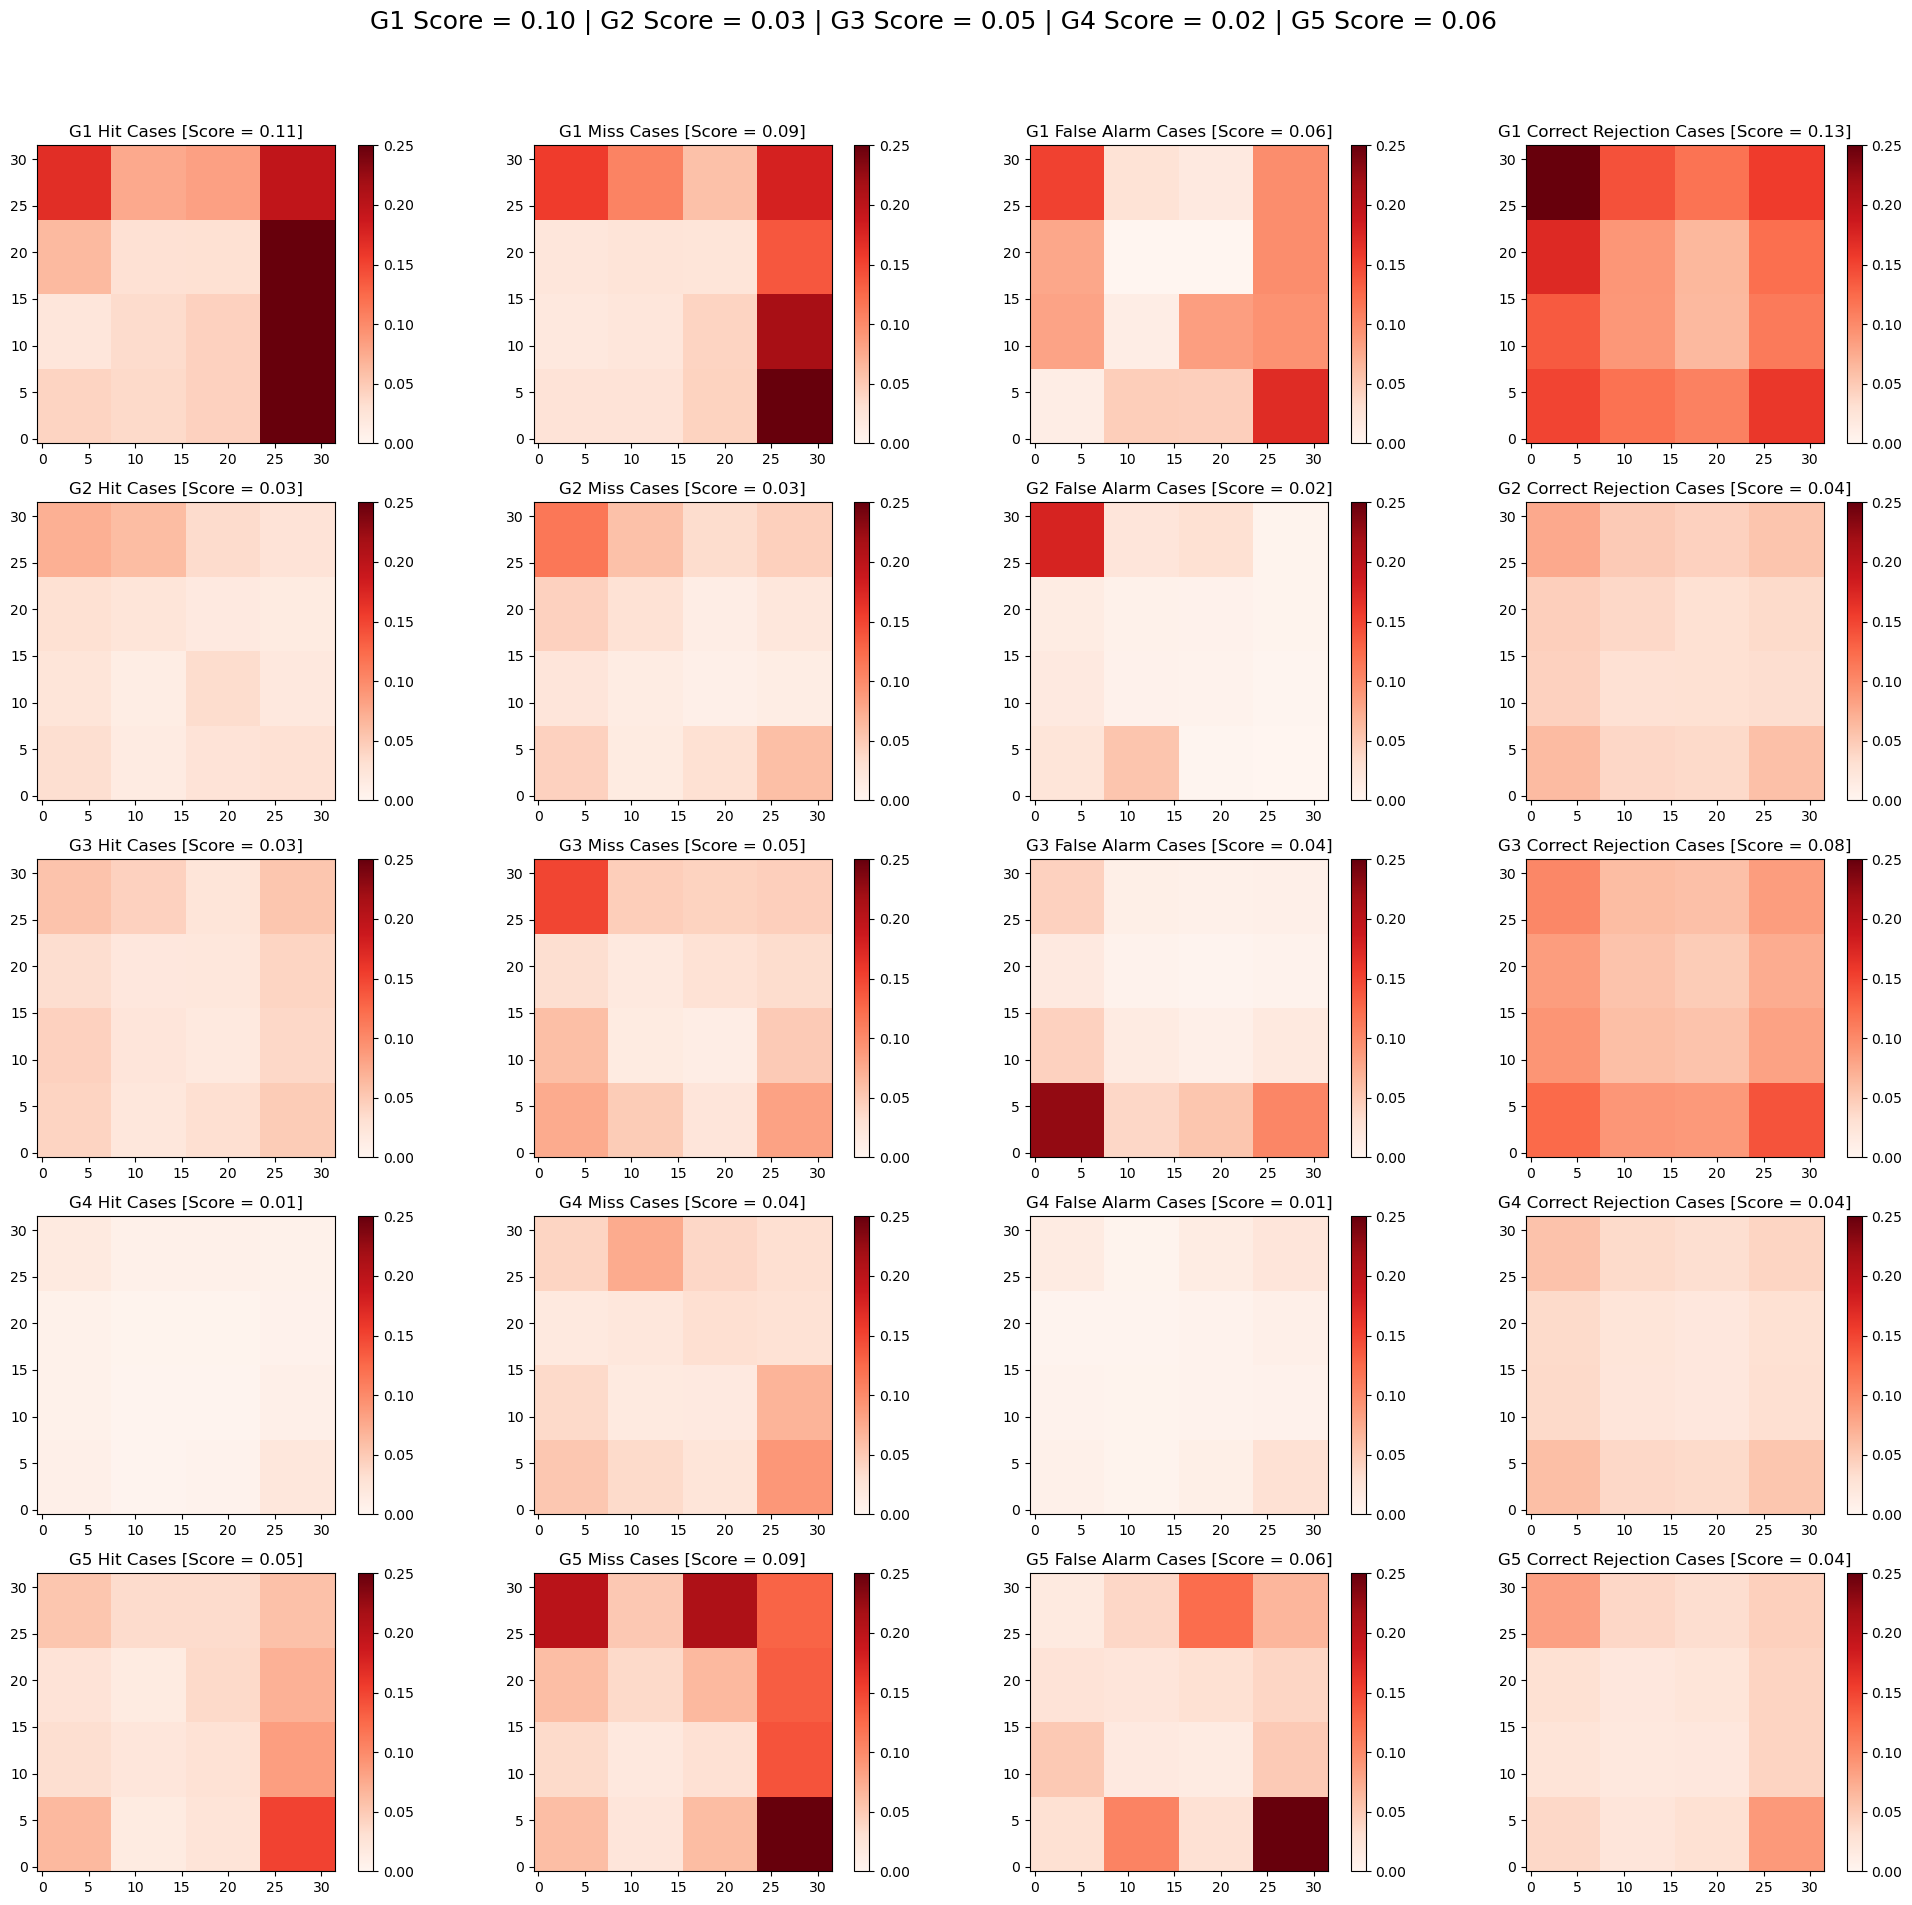

In [37]:
_ = inf.XAI_ALLCASES_PLOT(data_dict_pit, exp_name = '05_PIT_V2_LRP', threshold = 0.441, embd_type='PIT').global_plot(scale = 4)

### SVT

In [7]:
config_svt = sm.Get_model_config(img_size = 32, in_channel = 388, in_time = 4, embd_size = 1024, mlp_size = 512, 
                                      num_heads = 8, dropout = 0.3, num_layers  = 6, conv_type = '2d', embd_type = 'SVT').return_config()

In [8]:
FogNet = sm.SparkMET(config_svt, 
                           SaveDir = '/data1/fog/Hamid/SparkMET/EXPs/', 
                           Exp_Name = '02_SVT_BCE_0001_01_32_LPR')

model_svt, optimizer, loss_func = FogNet.compile(optmizer = 'adamw', loss = 'BCE', lr = 0.00005, wd = 0.03)

model_svt.load_state_dict(torch.load('/data1/fog/Hamid/SparkMET/EXPs/02_SVT_BCE_0001_01_32_LPR/best_model_02_SVT_BCE_0001_01_32_LPR.pth'))

The number of model's parameters = 108237826


<All keys matched successfully>

In [9]:
model_svt.eval()
attribution_generator_svt = LRP(model_svt)

In [10]:
data_dict_svt = {}

for batch in data_loader_training:
    # Assuming each batch is a dictionary with keys: 'input', 'class-label', 'vis', 'date_time'
    for i in range(len(batch['date_cycletime'])):
        date_cycletime = batch['date_cycletime'][i]
        data_dict_svt[date_cycletime] = {
            'date_time': batch['date_time'][i],
            'vis': batch['vis'][i],
            'input': batch['input'][i],
            'label_class': batch['label_class'][i],
        }

In [12]:
for date_time, data in data_dict_svt.items():

    transformer_attribution = attribution_generator_svt.generate_LRP(data['input'].unsqueeze(0).cuda(0), method="transformer_attribution", index=data['label_class']).detach()
    transformer_attribution = transformer_attribution.reshape(1, 9, 4, 4)
    transformer_attribution4 = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    data_dict_svt[date_time]['lpr'] = transformer_attribution4.data.cpu().numpy()

    transformer_attribution32 = torch.nn.functional.interpolate(transformer_attribution, scale_factor=8, mode='bilinear')
    transformer_attribution32 = transformer_attribution32.reshape(9, 32, 32)
    transformer_attribution32 = (transformer_attribution32 - transformer_attribution32.min()) / (transformer_attribution32.max() - transformer_attribution32.min())
    data_dict_svt[date_time]['lpr32'] = transformer_attribution32.data.cpu().numpy()

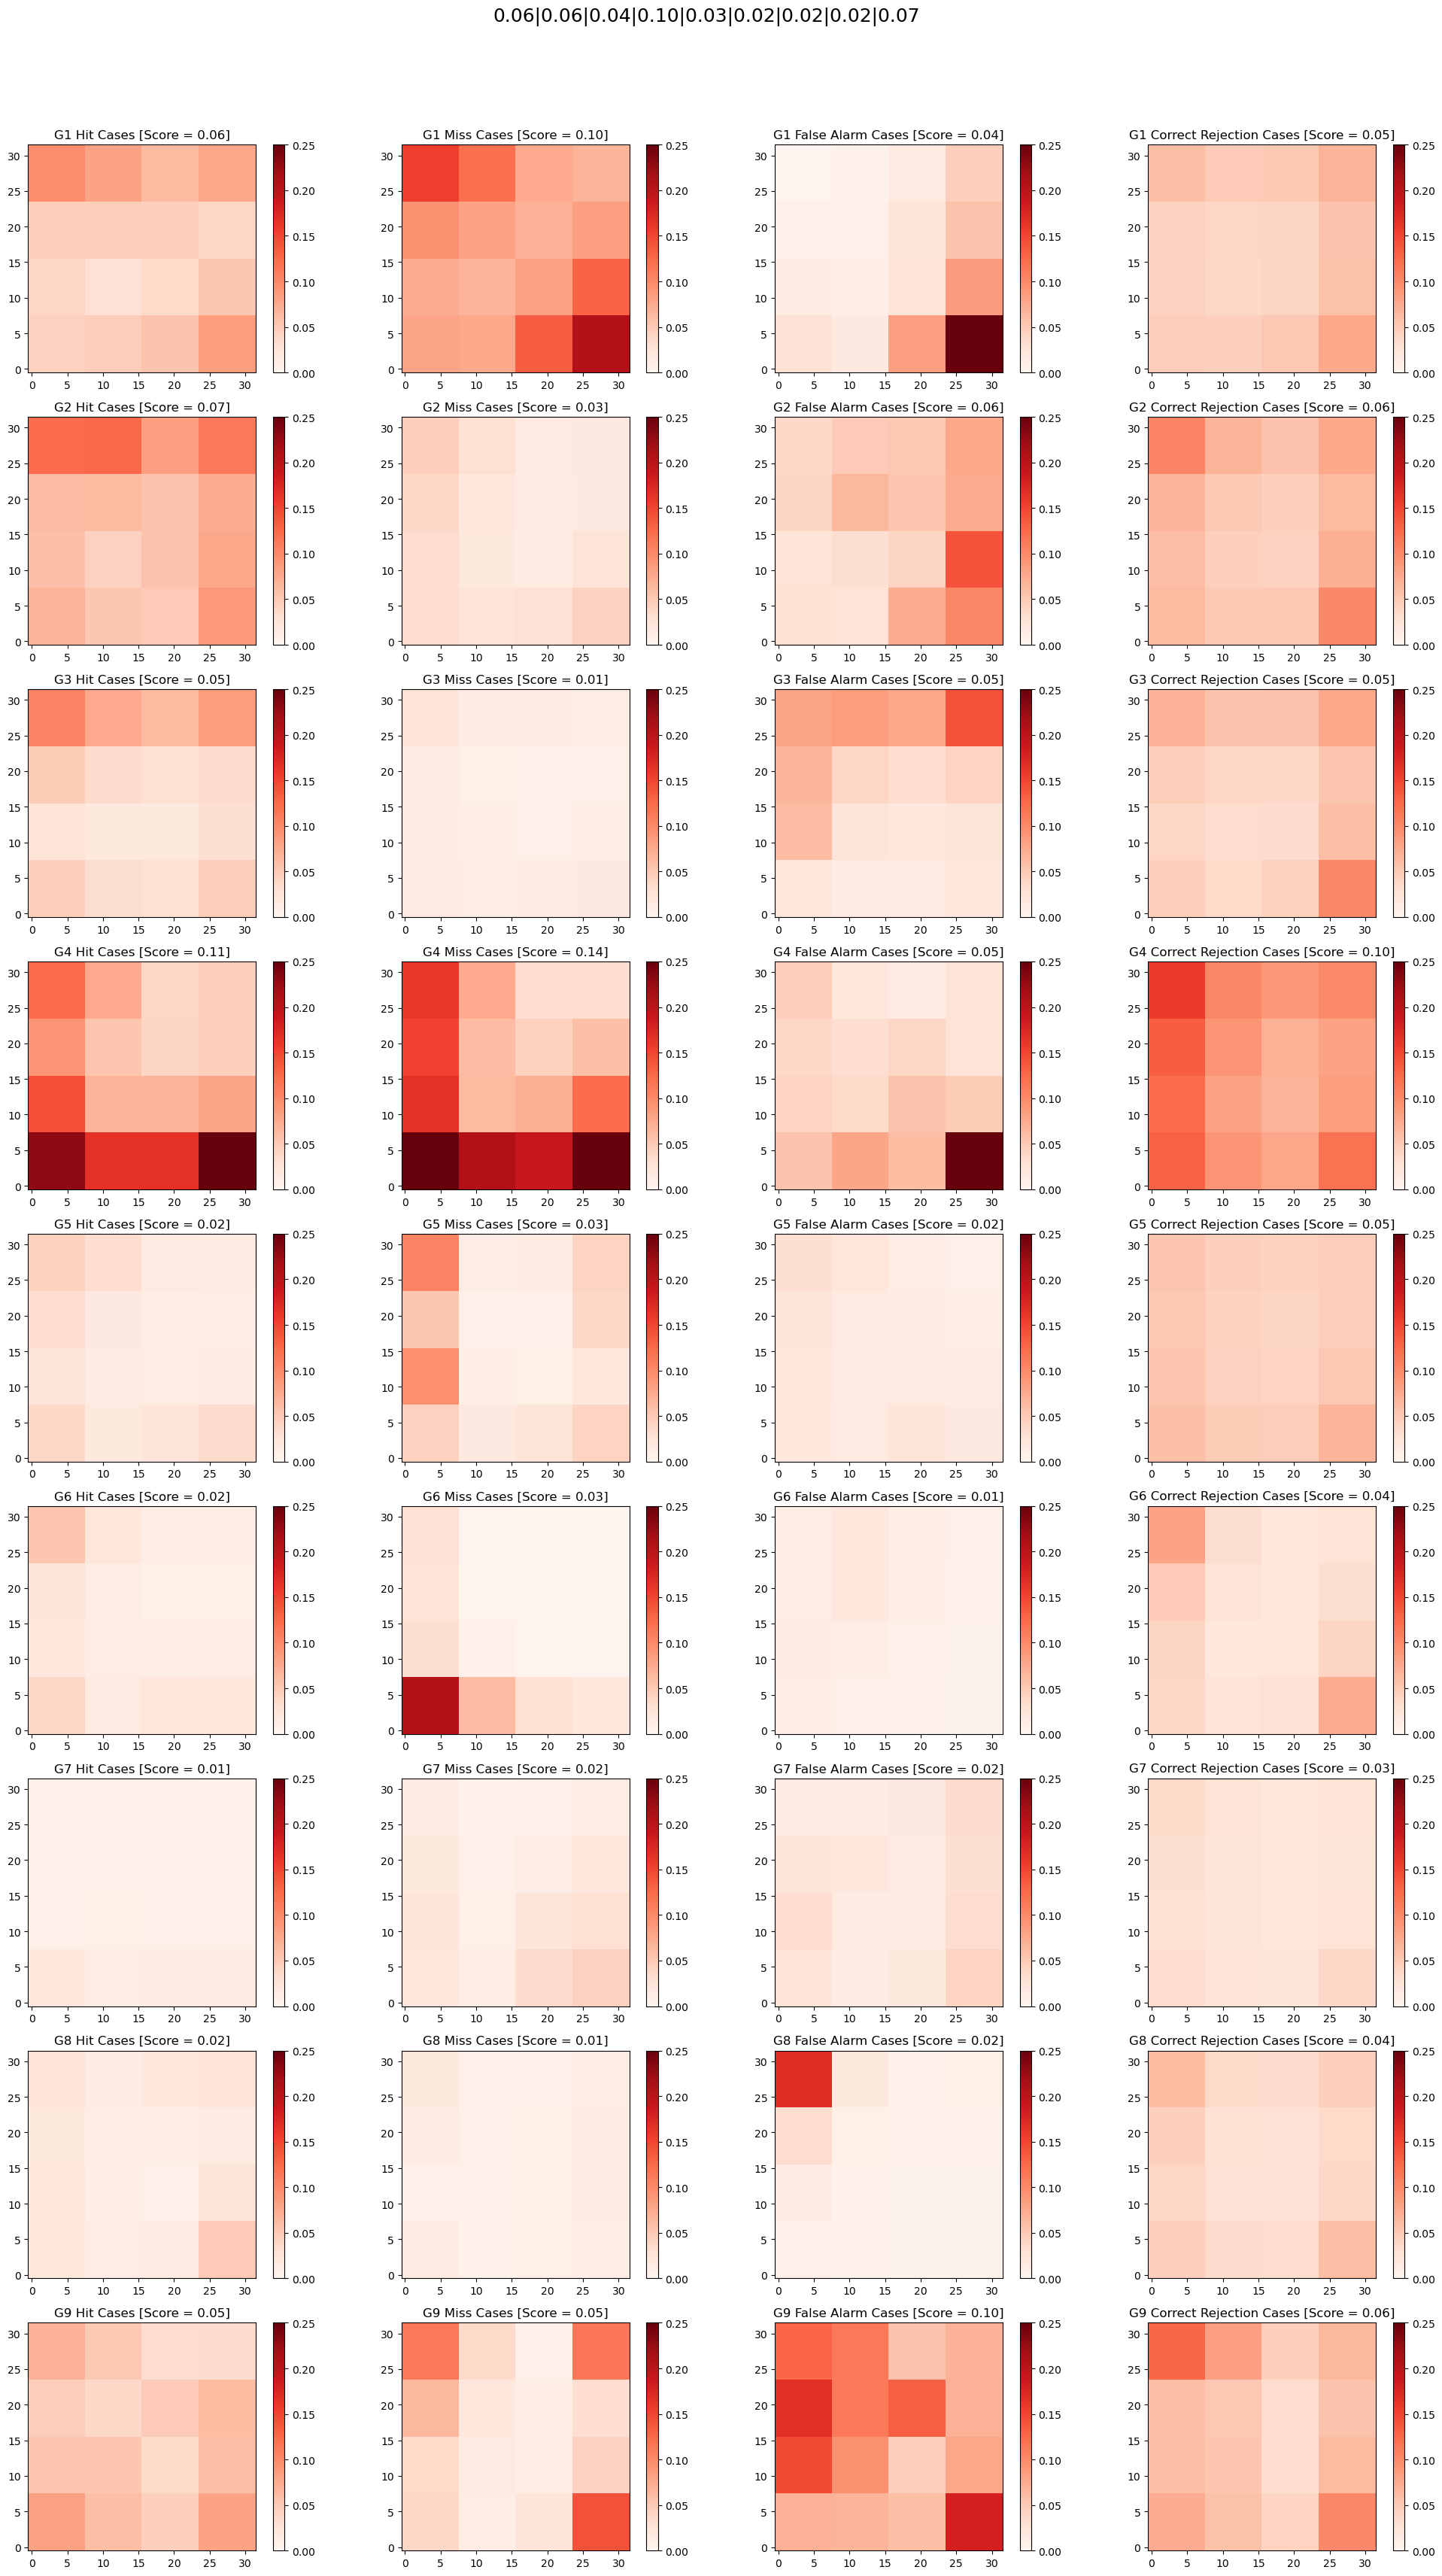

In [14]:
_ = inf.XAI_ALLCASES_PLOT(data_dict_svt, exp_name = '02_SVT_BCE_0001_01_32_LPR', threshold = 0.219, embd_type='SVT').global_plot(scale = 4)

In [14]:
def extract_data_cycletimes(lines, category_start):
    """Extracts data_cycletime values for a given category from the file lines."""
    start_index = None
    data_cycletimes = []

    # Find the start index for the category
    for i, line in enumerate(lines):
        if category_start in line:
            start_index = i
            break

    # Extract the data_cycletimes for the category
    if start_index is not None:
        for line in lines[start_index+1:]:
            if "Day" in line:
                parts = line.split(':')
                if len(parts) > 0:
                    data_cycletime = parts[0].strip().split(' ')[1]
                    data_cycletimes.append(data_cycletime)
            else:
                break  # Stop when category data ends

    return data_cycletimes


with open('/data1/fog/Hamid/SparkMET/inference/ensemble', 'r') as file:
    lines = file.readlines()

# Categories
categories = ["Hit Cases", "Miss Cases", "False Alarm Cases"]

# Extracting data_cycletimes for each category
hit_cases = extract_data_cycletimes(lines, "Hit Cases")
miss_cases = extract_data_cycletimes(lines, "Miss Cases")
false_alarm_cases = extract_data_cycletimes(lines, "False Alarm Cases")

# Displaying the extracted data
print("Hit Cases:", hit_cases)
print("Miss Cases:", miss_cases)
print("False Alarm Cases:", false_alarm_cases)

Hit Cases: ['20190203_0000', '20190203_0600', '20190203_1200', '20190203_1800', '20190206_0000', '20190216_0000', '20190217_0000', '20190217_0600', '20190222_1200', '20190223_0000', '20190223_0600', '20190226_1800', '20190227_0000', '20190227_0600', '20190227_1800', '20190228_0600', '20190302_0000', '20190302_0600', '20190302_1800', '20190303_0000', '20190303_0600', '20190310_0000', '20190310_0600', '20190311_0000', '20190311_0600', '20190312_0000', '20190312_0600', '20190404_0600', '20190405_0000', '20190405_0600', '20200113_1800', '20200114_0000', '20200114_0600', '20200114_1800', '20200115_0000', '20200116_0600', '20200304_0600', '20200311_0600', '20200322_0600', '20200407_0000', '20200407_0600', '20200408_0600', '20200409_0600', '20200419_0000']
Miss Cases: ['20181020_0000', '20181124_0600', '20181130_0000', '20181130_0600', '20181219_0600', '20181220_0000', '20190202_0000', '20190206_1800', '20190215_1800', '20190228_1200', '20191119_0600', '20191213_0600', '20191215_0000', '20200

In [ ]:
df, vvt_att_out, input_maps = FogNet.inference(model, data_loader_training)

print(f"input maps: {input_maps.shape} | att_maps: {vvt_att_out.shape}")

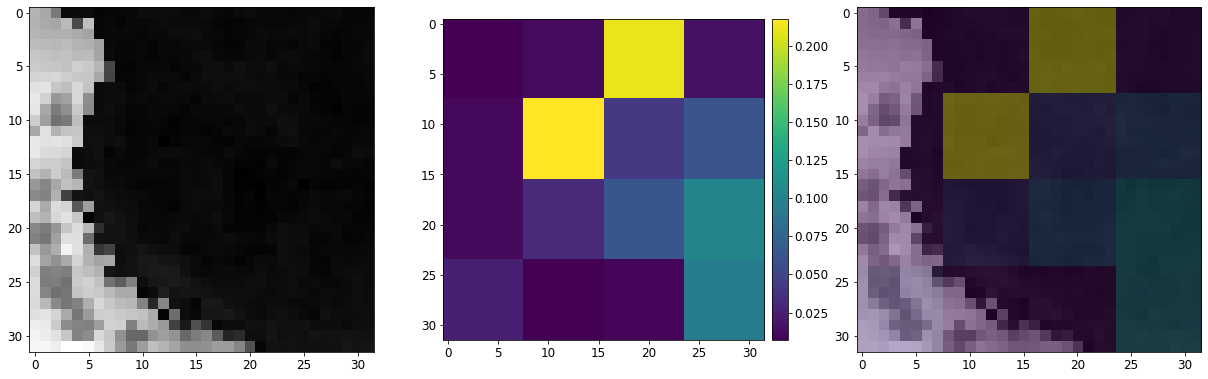

In [11]:
_ = engine.single_spatial_att_map(df, input_maps, vvt_att_out, global_case = 'Hit', local_date = None, head_avg = False)

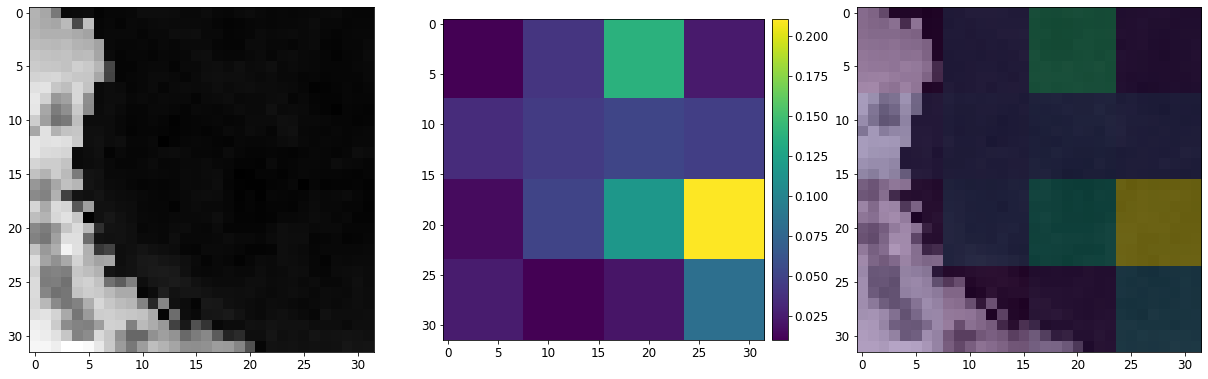

In [12]:
_ = engine.single_spatial_att_map(df, input_maps, vvt_att_out, global_case = 'Miss', local_date = None, head_avg = False)

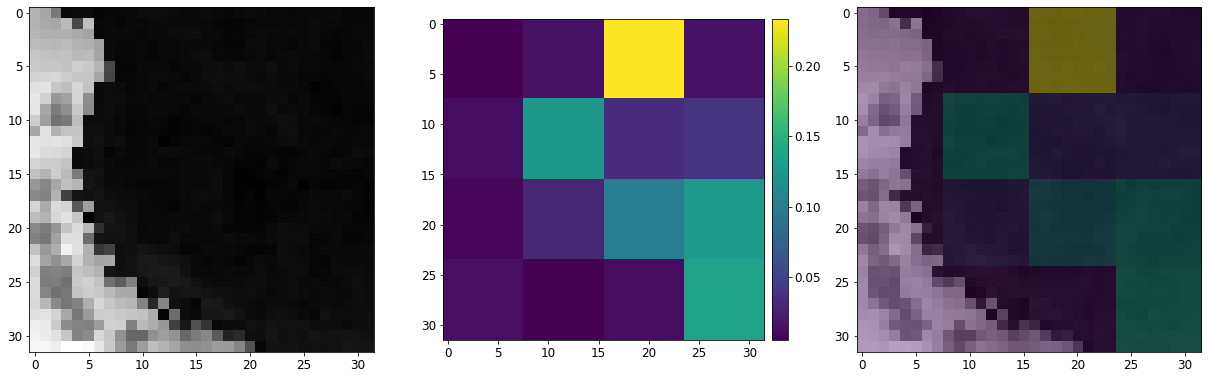

In [13]:
_ = engine.single_spatial_att_map(df, input_maps, vvt_att_out, global_case = 'FA', local_date = None, head_avg = False)

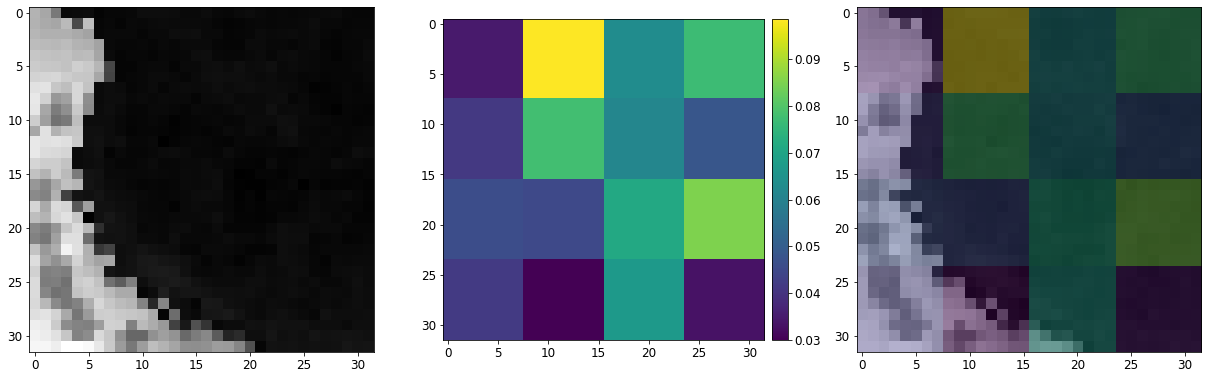

: 

In [14]:
_ = engine.single_spatial_att_map(df, input_maps, vvt_att_out, global_case = 'CR', local_date = None, head_avg = False)

In [40]:
### Hit cases: 
hit_cases = train_df[(train_df['ytrue'] == 1) & (train_df['fog_prob'] >= 0.52)]
hit_cases[50:60]

,date_time,round_time,date_cycletime,vis,ytrue,fog_prob,nonfog_prob
3925,20120201 17:55:00,20120201 18:00:00,20120201_1200,0.25,1,0.952516,0.047484
4121,20150121 11:55:00,20150121 12:00:00,20150121_0600,0.50,1,0.856329,0.143671
4235,20100403 12:05:00,20100403 12:00:00,20100403_0600,0.25,1,0.647420,0.352580
4263,20120123 05:55:00,20120123 06:00:00,20120123_0000,0.25,1,0.918872,0.081128
4311,20120224 05:55:00,20120224 06:00:00,20120224_0000,0.50,1,0.960936,0.039064
4374,20140226 05:55:00,20140226 06:00:00,20140226_0000,0.50,1,0.887594,0.112405
4425,20131118 11:55:00,20131118 12:00:00,20131118_0600,1.00,1,0.963190,0.036810
4458,20150317 05:55:00,20150317 06:00:00,20150317_0000,0.25,1,0.969912,0.030088
4652,20120313 05:55:00,20120313 06:00:00,20120313_0000,0.25,1,0.996515,0.003485
4689,20140301 11:55:00,20140301 12:00:00,20140301_0600,1.00,1,0.931736,0.068264


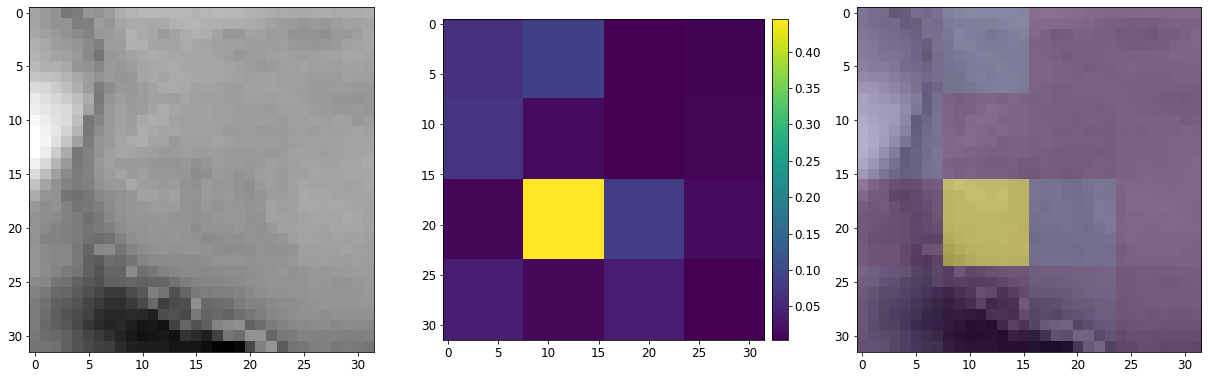

In [41]:
_ = engine.single_spatial_att_map(train_df, input_maps, vvt_att_out, 
                                  variable = 93, 
                                  date = '20150317_0000', head_avg = False)

In [19]:
### Miss cases: 
miss_cases = train_df[(train_df['ytrue'] == 1) & (train_df['fog_prob'] < 0.52)]
miss_cases

,date_time,round_time,date_cycletime,vis,ytrue,fog_prob,nonfog_prob
122,20090419 06:05:00,20090419 06:00:00,20090419_0000,0.50,1,0.113574,0.886426
130,20091214 00:05:00,20091214 00:00:00,20091213_1800,0.25,1,0.005803,0.994197
440,20161228 23:55:00,20161229 00:00:00,20161228_1800,0.25,1,0.491064,0.508936
683,20140209 11:55:00,20140209 12:00:00,20140209_0600,0.50,1,0.141451,0.858549
1079,20100107 12:00:00,20100107 12:00:00,20100107_0600,0.25,1,0.431169,0.568831
1082,20151208 11:55:00,20151208 12:00:00,20151208_0600,0.25,1,0.500000,0.500000
1389,20140218 11:55:00,20140218 12:00:00,20140218_0600,0.50,1,0.484078,0.515922
1471,20141205 11:55:00,20141205 12:00:00,20141205_0600,0.75,1,0.399387,0.600613
1558,20131216 11:55:00,20131216 12:00:00,20131216_0600,0.25,1,0.000294,0.999706
1645,20140406 05:55:00,20140406 06:00:00,20140406_0000,1.00,1,0.480519,0.519481


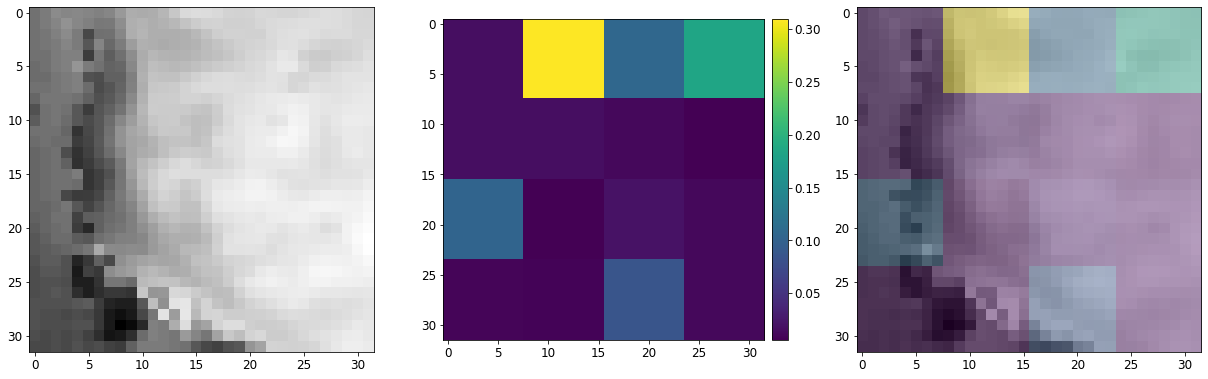

In [26]:
_ = engine.single_spatial_att_map(train_df, input_maps, vvt_att_out, 
                                  variable = 93, 
                                  date = '20150321_0000', head_avg = False)

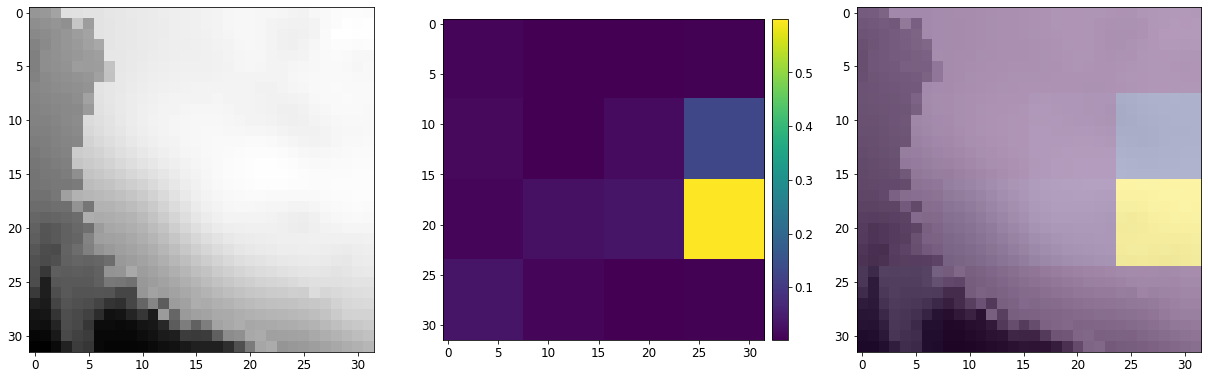

In [20]:
_ = engine.single_spatial_att_map(train_df, input_maps, vvt_att_out, 
                                  variable = 93, 
                                  date = '20161216_1200', head_avg = False)

In [21]:
false_alarms = train_df[(train_df['ytrue'] == 0) & (train_df['fog_prob'] >= 0.52)]
false_alarms

,date_time,round_time,date_cycletime,vis,ytrue,fog_prob,nonfog_prob
290,20120214 05:55:00,20120214 06:00:00,20120214_0000,9.0,0,0.688611,0.311389
528,20160412 11:55:00,20160412 12:00:00,20160412_0600,4.0,0,0.676573,0.323427
1091,20120323 11:55:00,20120323 12:00:00,20120323_0600,10.0,0,0.835979,0.164021
1776,20160316 05:55:00,20160316 06:00:00,20160316_0000,2.5,0,0.903790,0.096210
1878,20120222 05:55:00,20120222 06:00:00,20120222_0000,10.0,0,0.564324,0.435676
1946,20160302 11:55:00,20160302 12:00:00,20160302_0600,7.0,0,0.778241,0.221759
2052,20151224 11:55:00,20151224 12:00:00,20151224_0600,4.0,0,0.766489,0.233511
2684,20150404 05:55:00,20150404 06:00:00,20150404_0000,5.0,0,0.651531,0.348470
2797,20090327 06:05:00,20090327 06:00:00,20090327_0000,2.5,0,0.738093,0.261907
2828,20150317 17:55:00,20150317 18:00:00,20150317_1200,10.0,0,0.542701,0.457299


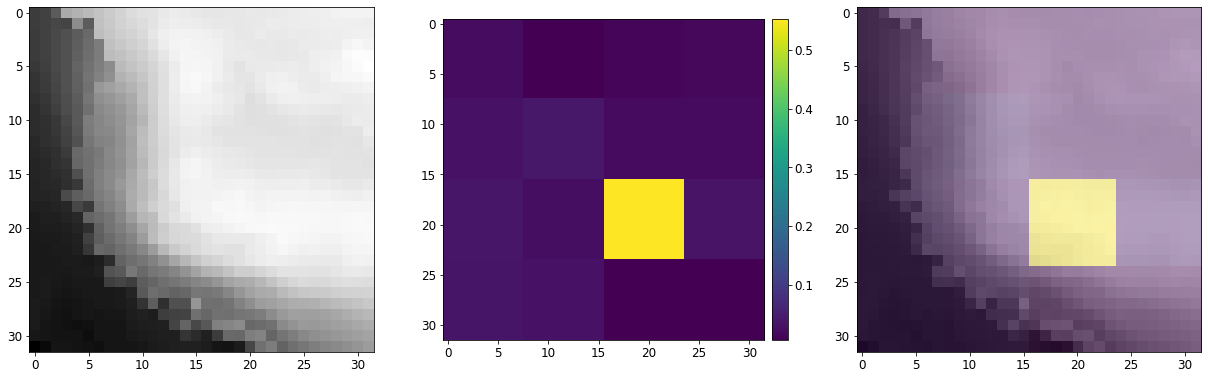

In [22]:
_ = engine.single_spatial_att_map(train_df, input_maps, vvt_att_out, 
                                  variable = 93, 
                                  date = '20141223_0000', head_avg = False)

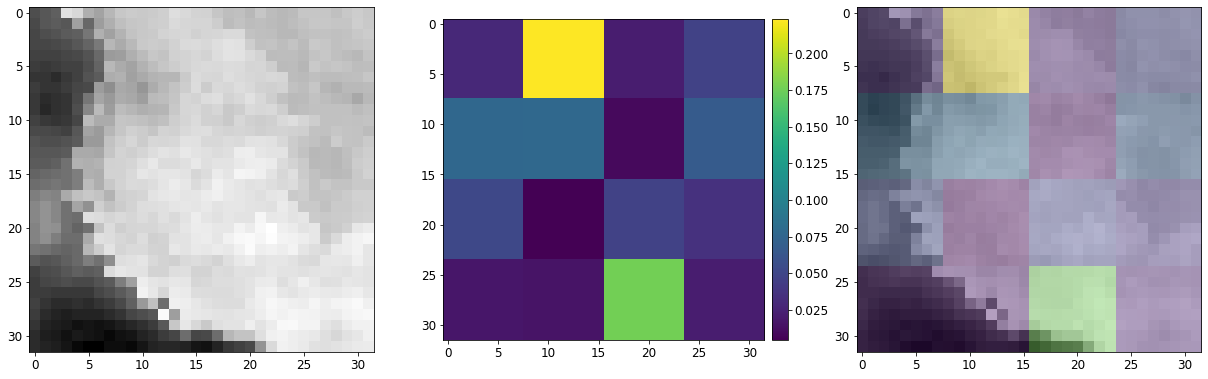

In [42]:
_ = engine.single_spatial_att_map(train_df, input_maps, vvt_att_out, 
                                  variable = 93, 
                                  date = '20150321_0600', head_avg = False)